In [18]:
using JuMP, Gurobi, Gadfly, DataFrames, ScikitLearn

### Create the OCT in the paper with a toy dataset

In [2]:
# generate XOR-like data
function f(x1::Float64, x2::Float64)
    if (x1 <= 0.5 && x2 <= 0.5) || (x1 > 0.5 && x2 > 0.5)
        return 1
    end
    return 2     
end

K = 2  # number of classes
p = 2  # number of features
n = 200  # number of data points
x = rand(n, p)
y = diag([f(x1, x2) for x1 = x[:, 1], x2 = x[:, 2]])
Y = reshape(vcat(-(y-1)*2+1, (y-1)*2-1), (n, p));  # needed in equation (15)

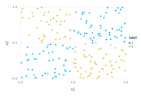

In [3]:
# plot data
df = DataFrame(x1=x[:, 1], x2=x[:, 2], label=y)
df[:label] = [string(x) for x in df[:label]] 
plot(df, x="x1", y="x2", color="label", Geom.point)

In [4]:
# find epsilon, needed in equation (13)
epsilon = Float64[]

for j in 1:p
    min_j = typemax(Int32)
    for i in 1:n-1
        diff = abs(x[i, j] - x[i+1, j])
        if diff < min_j
            min_j = diff
        end
    end
    append!(epsilon, min_j)
end

In [5]:
# find left and right ancestors, needed in equation (13), (14)
function get_ancestors(t)
    current_node = t
    Al = Int[]
    Ar = Int[]
    
    while current_node != 1
        parent = convert(Int, floor(current_node/2))
        if current_node % 2 == 0
            append!(Al, parent)
        else
            append!(Ar, parent)
        end
        current_node = parent
    end 
    
    return Al, Ar
end

get_ancestors (generic function with 1 method)

In [6]:
# set up model
m1 = Model(solver=GurobiSolver())

# parameters 
D = 2  # depth
N_min = 1  # min number of data points in each leaf
alpha = 0  # complexity penalty weight

T = 2^(D+1)-1  # number of nodes in the tree
Tb = convert(Int, floor(T/2))  # number of branch nodes

# variables
@variable(m1, a[1:p, 1:Tb], Bin)  # vector a for each branch node
@variable(m1, b[1:Tb])  # split value b
@variable(m1, d[1:Tb], Bin)  # d indicates if a branch node applies split
@variable(m1, z[1:n, Tb+1:T], Bin)  # z indicates if xi is in leaf node t
@variable(m1, l[Tb+1:T], Bin)  # l indicates if leaf node t contains any points
@variable(m1, c[1:K, Tb+1:T], Bin)  # ???
@variable(m1, Nt[Tb+1:T])  # total number of points in leaf node t
@variable(m1, Nkt[1:K, Tb+1:T])  # total number of points of label k in leaf node t
@variable(m1, L[Tb+1:T])  # loss at each leaf node

# constraints
@constraint(m1, [t = 1:Tb], sum(a[:, t]) == d[t])  # equation (2)
@constraint(m1, [t = 1:Tb], b[t] <= d[t])  # equation (3)
@constraint(m1, [t = 1:Tb], b[t] >= 0)  # equation (3)
@constraint(m1, [t = 2:Tb], d[t] <= d[convert(Int, floor(t/2))])  # equation (5)
@constraint(m1, [i = 1:n, t = Tb+1:T], z[i, t] <= l[t])  # equation (6)
@constraint(m1, [t = Tb+1:T], sum(z[:, t]) >= N_min*l[t])  # equation (7)
@constraint(m1, [i = 1:n], sum(z[i, :]) == 1)  # equation (8)

# equation (13), (14)
for t in Tb+1:T
    Al, Ar = get_ancestors(t)    
    for s in Ar, i in 1:n
        @constraint(m1, x[i, :]'*a[:, s]-b[s]-z[i, t]+1 >= 0)  # equation (14)
    end
    for s in Al, i in 1:n
        @constraint(m1, x[i, :]'*a[:, s]+minimum(epsilon) <= b[s]+(1+maximum(epsilon))*(1-z[i, t]))
    end
end

@constraint(m1, [k = 1:K, t = Tb+1:T], Nkt[k, t] == 0.5*sum((1+Y[:, k])'*z[:, t]))  # equation (15)
@constraint(m1, [t = Tb+1:T], Nt[t] == sum(z[:, t]))  # equation (16)
@constraint(m1, [t = Tb+1:T], sum(c[:, t]) == l[t])
@constraint(m1, [t = Tb+1:T], L[t] >= 0)  # equation (22)
@constraint(m1, [k = 1:K, t = Tb+1:T], L[t] >= Nt[t]-Nkt[k, t]-n*(1-c[k, t]))  # equation (20)
@constraint(m1, [k = 1:K, t = Tb+1:T], L[t] <= Nt[t]-Nkt[k, t]+n*c[k, t])  # equation (21)

# set up objective
@objective(m1, Min, sum(L)+alpha*sum(d));

In [7]:
@time status = solve(m1)
println("Objective value: ", getobjectivevalue(m1))

Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 2651 rows, 840 columns and 11318 nonzeros
Variable types: 19 continuous, 821 integer (821 binary)
Coefficient statistics:
  Matrix range     [5e-03, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 9 rows and 2 columns
Presolve time: 0.03s
Presolved: 2642 rows, 838 columns, 9725 nonzeros
Variable types: 3 continuous, 835 integer (819 binary)
Found heuristic solution: objective 99.0000000
Found heuristic solution: objective 98.0000000

Root relaxation: objective 0.000000e+00, 411 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    4   98.00000    0.00000   100%     -    0s
H    0     0                      97.000

In [8]:
println("Splitting value: ", getvalue(b))

Splitting value: [0.502096, 0.507247, 0.47488]


### Modify the OCT to allow the last split to be multivariate

In [9]:
# generate XOR-like data
function f(x1::Float64, x2::Float64)
    if (x1 <= 0.5 && x1 <= x2) || (x1 > 0.5 && x1 > x2)
        return 1
    end
    return 2     
end

K = 2  # number of classes
p = 2  # number of features
n = 200  # number of data points
x = rand(n, p)
y = diag([f(x1, x2) for x1 = x[:, 1], x2 = x[:, 2]])
Y = reshape(vcat(-(y-1)*2+1, (y-1)*2-1), (n, p));  # needed in equation (15)

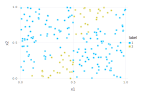

In [10]:
# plot data
df = DataFrame(x1=x[:, 1], x2=x[:, 2], label=y)
df[:label] = [string(x) for x in df[:label]] 
plot(df, x="x1", y="x2", color="label", Geom.point)

In [11]:
# set up model
m2 = Model(solver=GurobiSolver())

# parameters 
D = 2  # depth
N_min = 1  # min number of data points in each leaf
alpha = 0  # complexity penalty weight
mu = 0.005  # used in equation (13) for the multivariate case

T = 2^(D+1)-1  # number of nodes in the tree
Tb = convert(Int, floor(T/2))  # number of branch nodes
Tu = convert(Int, floor(Tb/2))  # number of branch nodes that apply univaraite split

# variables
@variable(m2, au[1:p, 1:Tu], Bin)  # vector au for branch nodes that apply univariate split
@variable(m2, -1 <= am[1:p, Tu+1:Tb] <= 1)  # vector am for branch nodes that apply multivariate split
@variable(m2, bu[1:Tu])  # split value b for branch nodes that apply univariate split
@variable(m2, -1 <= bm[Tu+1:Tb] <= 1)  # split value b for branch nodes that apply multivariate split
@variable(m2, z[1:n, Tb+1:T], Bin)  # z indicates if xi is in leaf node t
@variable(m2, l[Tb+1:T], Bin)  # l indicates if leaf node t contains any points
@variable(m2, c[1:K, Tb+1:T], Bin)  # ???
@variable(m2, Nt[Tb+1:T])  # total number of points in leaf node t
@variable(m2, Nkt[1:K, Tb+1:T])  # total number of points of label k in leaf node t
@variable(m2, L[Tb+1:T])  # loss at each leaf node

# constraints
@constraint(m2, [t = 1:Tu], sum(au[:, t]) == 1)  # equation (2) for univariate split
# we don't need a constraint for am because we are always splitting?
@constraint(m2, [t = 1:Tu], bu[t] <= 1)  # equation (3)
@constraint(m2, [t = 1:Tu], 0 <= bu[t])  # equation (3)
@constraint(m2, [i = 1:n, t = Tb + 1:T], z[i, t] <= l[t])  # equation (6)
@constraint(m2, [t = Tb+1:T], sum(z[:, t]) >= N_min*l[t])  # equation (7)
@constraint(m2, [i = 1:n], sum(z[i, :]) == 1)  # equation (8)

# equation (13), (14)
for t in Tb+1:T
    Al, Ar = get_ancestors(t)    
    for s in Ar, i in 1:n
        if s <= Tu
            @constraint(m2, x[i, :]'*au[:, s]-bu[s]-z[i, t]+1 >= 0)  # equation (14) for univariate case
        else
            @constraint(m2, x[i, :]'*am[:, s]-bm[s]-2*z[i, t]+2 >= 0)  # equation (14) for multivariate case
        end
    end
    for s in Al, i in 1:n
        if s <= Tu
            @constraint(m2, x[i, :]'*au[:, s]+minimum(epsilon) <= bu[s]+(1+maximum(epsilon))*(1-z[i, t]))
        else
            @constraint(m2, x[i, :]'*am[:, s]+mu <= bm[s]+(2+mu)*(1-z[i,t]))
        end
    end
end

@constraint(m2, [k = 1:K, t = Tb+1:T], Nkt[k, t] == 0.5*sum((1+Y[:, k])'*z[:, t]))  # equation (15)
@constraint(m2, [t = Tb+1:T], Nt[t] == sum(z[:, t]))  # equation (16)
@constraint(m2, [t = Tb+1:T], sum(c[:, t]) == l[t])
@constraint(m2, [t = Tb+1:T], L[t] >= 0)  # equation (22)
@constraint(m2, [k = 1:K, t = Tb+1:T], L[t] >= Nt[t]-Nkt[k, t]-n*(1-c[k, t]))  # equation (20)
@constraint(m2, [k = 1:K, t = Tb+1:T], L[t] <= Nt[t]-Nkt[k, t]+n*c[k, t])  # equation (21)

# set up objective
@objective(m2, Min, sum(L));

In [12]:
@time status = solve(m2)
println("Objective value: ", getobjectivevalue(m2))

Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 2643 rows, 837 columns and 11300 nonzeros
Variable types: 23 continuous, 814 integer (814 binary)
Coefficient statistics:
  Matrix range     [3e-03, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 7 rows and 1 columns
Presolve time: 0.02s
Presolved: 2636 rows, 836 columns, 8908 nonzeros
Variable types: 7 continuous, 829 integer (813 binary)
Found heuristic solution: objective 48.0000000

Root relaxation: objective 0.000000e+00, 446 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   18   48.00000    0.00000   100%     -    0s
     0     0    0.00000    0  249   48.00000    0.00000   100%     -    0s
     0     0

In [13]:
println("Univariate splitting value: ", getvalue(bu))
println("Univariate splitting feature: ", getvalue(au))
println("Multivariate plitting value: ", getvalue(am))

Univariate splitting value: [0.500122]
Univariate splitting feature: [1.0; 0.0]
Multivariate plitting value: am: 2 dimensions:
[1,:]
  [1,2] = 0.8648989905253357
  [1,3] = 1.0
[2,:]
  [2,2] = -1.0
  [2,3] = -1.0


In [27]:
@sk_import tree: DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_depth=2)
@time ScikitLearn.fit!(tree_model, x, y)
println("Accuracy of decision tree with depth 2: ", ScikitLearn.score(tree_model, x, y))

  0.001248 seconds (56 allocations: 2.250 KiB)
Accuracy of decision tree with depth 2: 0.835
